## Wykorzystane moduły

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from data_processing import transform
from modeling.utils import evaluate
from data_processing.settings import BINARY_FEATURES, CATEGORY_FEATURES

In [3]:
np.random.seed(42)

# Załadowanie danych treningowych i testowych

In [4]:
dataset = transform(pd.read_pickle('data/dev_dataset.pkl')).dropna()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
dataset

,loan_amnt,term,int_rate,annual_inc,dti,fico_range_low,open_acc,revol_bal,initial_list_status,application_type,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_util,disbursement_method,target,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
93313,12000.0,0,8.18,36000.0,26.80,715.0,15.0,8356.0,1,0,0.0,4.0,2048.0,29.9,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
644892,14000.0,0,5.32,61000.0,16.86,790.0,19.0,10064.0,1,0,0.0,5.0,5169.0,10.6,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
682290,4500.0,0,11.99,35000.0,19.72,685.0,8.0,3281.0,0,0,0.0,8.0,11356.0,41.5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1778326,5400.0,0,7.90,57783.0,15.74,720.0,10.0,12112.0,1,0,0.0,1.0,2500.0,83.9,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1994376,10000.0,1,12.79,34000.0,6.81,675.0,16.0,7430.0,1,0,0.0,5.0,3720.0,33.9,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149660,7000.0,0,15.61,20000.0,20.47,675.0,9.0,6674.0,1,0,0.0,4.0,742.0,81.7,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
692722,19200.0,1,8.39,86000.0,6.96,680.0,10.0,16200.0,1,0,0.0,3.0,21744.0,56.5,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
17462,6000.0,0,13.18,23000.0,32.20,670.0,12.0,5486.0,1,0,0.0,5.0,1258.0,40.8,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
119046,28000.0,0,7.89,150000.0,13.05,745.0,9.0,88641.0,0,0,0.0,2.0,64237.0,68.4,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [6]:
dataset = dataset.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.1))
X_train = dataset.drop(columns='target')
y_train = (dataset.target == 0).astype(int) #przez pomyłkę zakodowano wcześniej na odwrót

In [7]:
testset = transform(pd.read_pickle('data/test_dataset.pkl')).dropna()
X_test = testset.drop(columns='target')
y_test = (testset.target == 0).astype(int) #przez pomyłkę zakodowano wcześniej na odwrót

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
cont_features = list(set(X_train.columns) - set(BINARY_FEATURES + CATEGORY_FEATURES))

Zadeklarowane zmienną zbierającą wyniki z kolejnych modelowań

In [9]:
results = []

## Modelowanie

In [10]:
tsh = 0.22

### XGBoost

In [11]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

meval = evaluate(xgb_clf, 'XGBoost', X_train, y_train, X_test, y_test, tsh)
results = results + meval
meval

[{'accuracy': 0.6461578500925355,
  'auc': 0.7208252042740896,
  'data': 'train',
  'model': 'XGBoost',
  'sensitivity': 0.6880785535080889,
  'specifity': 0.6341378711581872},
 {'accuracy': 0.6405505436039787,
  'auc': 0.7136474950353994,
  'data': 'test',
  'model': 'XGBoost',
  'sensitivity': 0.6788276890013518,
  'specifity': 0.6296000634662489}]

### XGBoost - RandomSearch

Ponieważ XGBoost jest zazwyczaj dość skutecznym modelem, nawet w domyślnej konfiguracji (nie udało mi się nigdy znacząco poprawić wyników używając GridSearch), a przeszukiwanie zachłanne jest kosztowne obliczeniowo, wybrano medotę Random Search.

In [12]:
hparams = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'n_estimators':[50, 100, 200],
    'max_depth':[3, 6, 10],
    'gamma': [0, 1, 5, 10],
  }

xgb_search = RandomizedSearchCV(XGBClassifier(), hparams)
xgb_search.fit(X_train, y_train)

meval = evaluate(xgb_search, 'XGBoost_RandomSearch', X_train, y_train, X_test, y_test, tsh)
results = results + meval
meval

[{'accuracy': 0.6546017119062307,
  'auc': 0.734164400953318,
  'data': 'train',
  'model': 'XGBoost_RandomSearch',
  'sensitivity': 0.7004066095683018,
  'specifity': 0.6414680127998412},
 {'accuracy': 0.6436078340658493,
  'auc': 0.7153137188001825,
  'data': 'test',
  'model': 'XGBoost_RandomSearch',
  'sensitivity': 0.6792609795833477,
  'specifity': 0.6334080383970806}]

Uzyskano wyniki zbliżone do modelu z domyślnie ustawionymi hiperparametrami

### Regresja logistyczna

In [13]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cont_features] = scaler.fit_transform(X_train_scaled[cont_features])
X_test_scaled[cont_features] = scaler.transform(X_test_scaled[cont_features])

log_reg_clf = LogisticRegression()
log_reg_clf.fit(X_train_scaled, y_train)

meval = evaluate(
    log_reg_clf, 'LogisticRegression',
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    tsh
    )

results = results + meval
meval

[{'accuracy': 0.6354777143738433,
  'auc': 0.7078671956822371,
  'data': 'train',
  'model': 'LogisticRegression',
  'sensitivity': 0.6784756466822389,
  'specifity': 0.6231488601691761},
 {'accuracy': 0.6336687485542447,
  'auc': 0.7077096522574587,
  'data': 'test',
  'model': 'LogisticRegression',
  'sensitivity': 0.6782384138098374,
  'specifity': 0.6209180789559802}]

Ponownie uzyskano zbliżone wyniki. Wcześniej dokonano standaryzacji zmiennyh ciągłych.

### Regresja logistyczna z selekcją cech na podstawie istoności określonej przez model XGBoost

In [14]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cont_features] = scaler.fit_transform(X_train_scaled[cont_features])
X_test_scaled[cont_features] = scaler.transform(X_test_scaled[cont_features])

for features in [1, 10, 20, 30]:
  log_reg_sfm_clf = LogisticRegression()
  selector = SelectFromModel(estimator=xgb_clf, prefit=True, max_features=features, threshold=-np.inf)

  log_reg_sfm_clf.fit(selector.transform(X_train_scaled), y_train)
  meval = evaluate(
      log_reg_sfm_clf, f'LogisticRegression_SelectFromModel_{features}_features',
      selector.transform(X_train_scaled), y_train,
      selector.transform(X_test_scaled), y_test,
      tsh
      )
  
  print(meval)

  results = results + meval

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[{'model': 'LogisticRegression_SelectFromModel_1_features', 'data': 'train', 'accuracy': 0.6379260487353485, 'sensitivity': 0.6142399861579722, 'specifity': 0.6447175848981718, 'auc': 0.6808170723016179}, {'model': 'LogisticRegression_SelectFromModel_1_features', 'data': 'test', 'accuracy': 0.6370113347212584, 'sensitivity': 0.6088079309508129, 'specifity': 0.645079878224135, 'auc': 0.6800701462755833}]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[{'model': 'LogisticRegression_SelectFromModel_10_features', 'data': 'train', 'accuracy': 0.6279592072794571, 'sensitivity': 0.6810277705683883, 'specifity': 0.6127427876863543, 'auc': 0.7018219310463664}, {'model': 'LogisticRegression_SelectFromModel_10_features', 'data': 'test', 'accuracy': 0.6247860282211427, 'sensitivity': 0.6789663419875905, 'specifity': 0.6092859055344553, 'auc': 0.7004321942439472}]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[{'model': 'LogisticRegression_SelectFromModel_20_features', 'data': 'train', 'accuracy': 0.6354487970388649, 'sensitivity': 0.678259364996972, 'specifity': 0.6231736660630566, 'auc': 0.7076104389072971}, {'model': 'LogisticRegression_SelectFromModel_20_features', 'data': 'test', 'accuracy': 0.6331058678386923, 'sensitivity': 0.6781344240701584, 'specifity': 0.620223916859214, 'auc': 0.7074800313226557}]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[{'model': 'LogisticRegression_SelectFromModel_30_features', 'data': 'train', 'accuracy': 0.6354777143738433, 'sensitivity': 0.6785189030192923, 'specifity': 0.623136457222236, 'auc': 0.7078673330277867}, {'model': 'LogisticRegression_SelectFromModel_30_features', 'data': 'test', 'accuracy': 0.6336648932068779, 'sensitivity': 0.6782210821865576, 'specifity': 0.6209180789559802, 'auc': 0.7077084275920777}]


### Regresja logistyczna z krokową selekcją cech

In [15]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cont_features] = scaler.fit_transform(X_train_scaled[cont_features])
X_test_scaled[cont_features] = scaler.transform(X_test_scaled[cont_features])

log_reg_sfs_clf = LogisticRegression()
selector = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=10, n_jobs=-1)
  
log_reg_sfs_clf.fit(selector.fit_transform(X_train_scaled, y_train), y_train)
 
meval = evaluate(
    log_reg_sfs_clf, f'LogisticRegression_SelectStepwise',
    selector.transform(X_train_scaled), y_train,
    selector.transform(X_test_scaled), y_test,
    tsh
    )

results = results + meval
print(meval)

[{'model': 'LogisticRegression_SelectStepwise', 'data': 'train', 'accuracy': 0.6689543491671808, 'sensitivity': 0.496452980361623, 'specifity': 0.7184158956167985, 'auc': 0.6466442669273245}, {'model': 'LogisticRegression_SelectStepwise', 'data': 'test', 'accuracy': 0.6683707302027913, 'sensitivity': 0.49589240528267875, 'specifity': 0.7177140250493351, 'auc': 0.6466053173321225}]


### Drzewo decyzyjne z pruningiem

Celem znalezienie jak najlepszej masymalnej głębokości, sprawdzono kilka możliwości i wybrano najlepszą.

[{'model': 'DecisionTreeClassifier', 'data': 'train', 'accuracy': 0.6427263263417643, 'sensitivity': 0.6605242668050869, 'specifity': 0.6376230992483815, 'auc': 0.7054306443205716}, {'model': 'DecisionTreeClassifier', 'data': 'test', 'accuracy': 0.6358740072480531, 'sensitivity': 0.6482547055357205, 'specifity': 0.632332087147093, 'auc': 0.6957753190568357}]


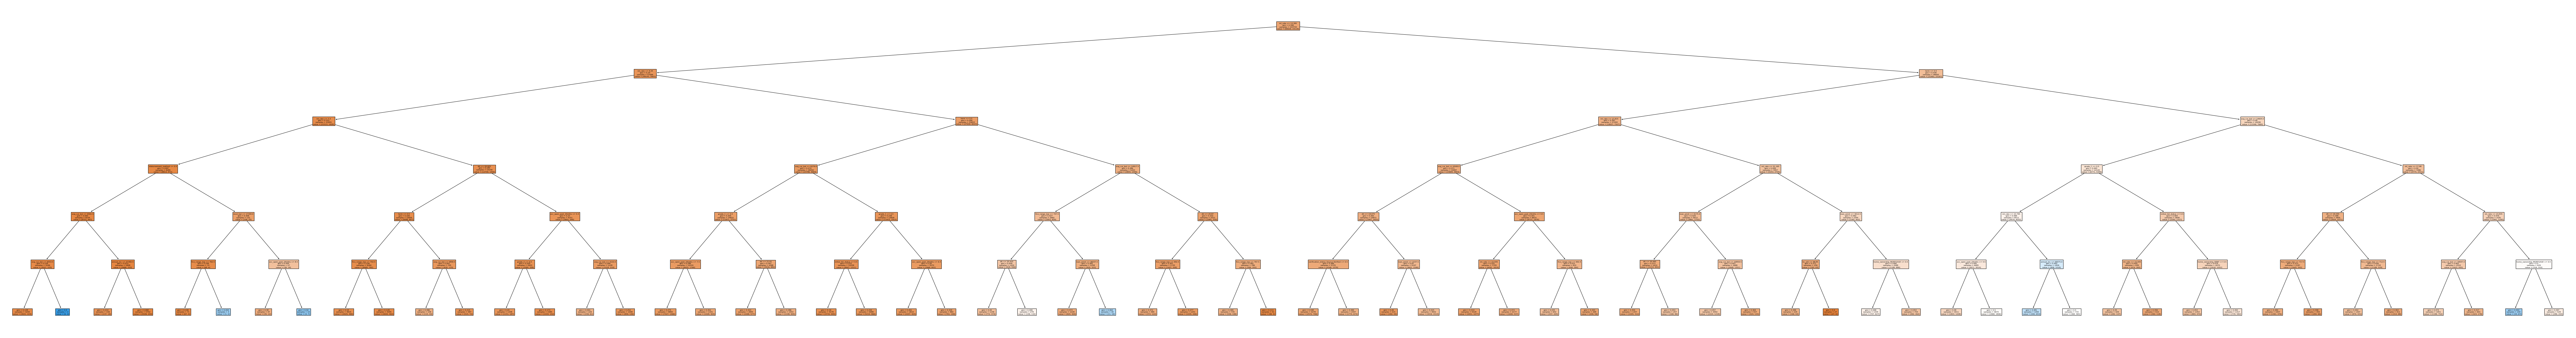

In [16]:
hparams = {
    'max_depth':[3, 6, 10, 20, 30],
  }

dt_search = GridSearchCV(DecisionTreeClassifier(), hparams)
dt_search.fit(X_train, y_train)

dt_clf = DecisionTreeClassifier(**dt_search.best_params_).fit(X_train, y_train)

meval = evaluate(
    dt_clf, f'DecisionTreeClassifier',
    X_train, y_train,
    X_test, y_test,
    tsh
    )
results += meval
print(meval)


plt.figure(figsize=(150, 20))
_ = plot_tree(dt_search.best_estimator_, filled=True, feature_names=X_train.columns)
plt.savefig('modeling/plots/decision_tree')

### Wyniki

In [17]:
pd.DataFrame(results)

,model,data,accuracy,sensitivity,specifity,auc
0,XGBoost,train,0.646158,0.688079,0.634138,0.720825
1,XGBoost,test,0.640551,0.678828,0.629600,0.713647
2,XGBoost_RandomSearch,train,0.654602,0.700407,0.641468,0.734164
3,XGBoost_RandomSearch,test,0.643608,0.679261,0.633408,0.715314
4,LogisticRegression,train,0.635478,0.678476,0.623149,0.707867
5,LogisticRegression,test,0.633669,0.678238,0.620918,0.707710
6,LogisticRegression_SelectFromModel_1_features,train,0.637926,0.614240,0.644718,0.680817
7,LogisticRegression_SelectFromModel_1_features,test,0.637011,0.608808,0.645080,0.680070
8,LogisticRegression_SelectFromModel_10_features,train,0.627959,0.681028,0.612743,0.701822
9,LogisticRegression_SelectFromModel_10_features,test,0.624786,0.678966,0.609286,0.700432


Wyniki nie są zadowalające. Co więcej nie stwierdzono aby mocno się od sieibe różniły. Sugeruje to że szanse poprawy leżą bardziej po stronie dokładniejszej analizy danych i wstępnego przetwarzania. Możliwe również, że jedna z cech bardzo wpływa na wyniki (ciekawym jest fakt, iż Regresja Logistyczna oparta o jedną cechę wskazaną przez XGBoosta daje już wynik bliski pozostałym) i sprawia, że wszystkie modele działają podobnie. Oczywsity jest też wpływ faktu, iż dane są bardzo niezrównoważone - czterokrotnie większa liczba spłaconych kredytów. Warto jednak zwrócić uwagę, że inne wyniki na Kaggle dla niniejszego zbioru, nie były znacząco lepsze.